In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import torch
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.data.transforms import *
from fastai2.distributed import *

In [3]:
import fastai2

In [4]:
%matplotlib inline

In [5]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', -1)

/home/auri/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2

In [7]:
class TMA:
    diameter_spot = 1200
    def __init__(self, tma_path, file, img_path_tif):
        self.meta_fn = file
        self.meta_path = tma_path
        self.img_path_tif = img_path_tif
        self.name = file.strip('.txt')[len('TMA results - '):]
        #self.spots = None #self.load_spots_meta()
        #self.img_tif = None #self.load_img_tif()

    @property
    def img_tif(self):
        self.__img_tif = self.load_img_tif()
        return self.__img_tif
    
    @property
    def spots(self):
        self.__spots = self.load_spots_meta()
        return self.__spots
        
    def load_tma_meta(self):
        df1 = pd.read_csv(os.path.join(self.meta_path, self.meta_fn), names=['fn', 'missing','X', 'Y', 'ID'], sep='\t', skiprows=[0])
        return df1
    
    def load_img_tif(self):
        a = None
        try:
            a = openslide.OpenSlide(os.path.join(self.img_path_tif, self.name + '.tif'))
        except: 
            print(f"BAD {self.name}.tif")
        return a
    
    def load_spots_meta(self):
        spots = []
        for index, rows in self.load_tma_meta().iterrows():
            spots.append(Spot(self.diameter_spot, 
                              rows.fn, rows.missing, (rows.X, rows.Y), rows.ID,
                        self.meta_path, self))
        return spots


In [8]:
class Spot: 
    def __init__(self, diameter, name, missing, center, ID, img_path_jpg, tma):
        self.path_jpg = img_path_jpg
        self.diameter = diameter #in micrometers
        self.name = name
        self.center = center #in micrometers
        self.missing = missing
        self.ID = ID
        self.TMA = tma
        self.tiles = []
        
    def load_img_jpg(self):
        s = openslide.ImageSlide(os.path.join(self.path_jpg, self.name + '.jpg'))
        #regions to be read with method s.read_region()
        return s
    
    #get spot center coordinates in pixels
    def get_center_pixel(self):
        tma = self.TMA.img_tif
        c_x, c_y = self.center 
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y']) #mpp  - 0.25  micras per pixel
        pc_x, pc_y = int(c_x / float(mpp_x)),int(c_y / float(mpp_y))
        return pc_x, pc_y
    
    #return radious in pixels both at full magnification (level = 0) and at a given zoom-out level
    def get_radious_pixel(self, level):
        tma = self.TMA.img_tif
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y'])
        #mpp = (mpp_x**2 + mpp_y**2)**0.5
        pspot_radio = int(self.diameter/ mpp_x / 2 )
        pzoom_radio = int( pspot_radio/ 2**level ) #with each increasing level the image is reduced half size 
        return pspot_radio, pzoom_radio
    
    #return spot circunference's north and sud y-coordinates (absolute positions in level 0) 
    #given a relative position from 0 (left) to 1 (right) in the spot diameter in axis x
    def get_circle_coordinates_pixel(self, rel_pos_diameter_x = .5): #return by default the y-coordinates for x fixed at center
        pc_x, pc_y = self.get_center_pixel()
        pspot_radio, _ = self.get_radious_pixel(0)
        x = int(pc_x - pspot_radio + rel_pos_diameter_x*(pspot_radio*2))
        if (( x + pspot_radio < pc_x) or ( x - pspot_radio > pc_x)): #x should be in circle diameter (pc_x - pspot_radio, pc_x + pspot_radio)
            return x, np.nan, np.nan
        root = (pspot_radio**2 - (x - pc_x)**2)**0.5
        y_north = int( -root + pc_y)
        y_sud = int( root + pc_y)
        return x, y_north, y_sud
    
    #check (true or false) if there is scarce tissue in an image
    @staticmethod
    def check_scarce_tissue(tile_image): 
        s = np.mean(tile_image, axis = 2) #collapse 3 color channels into 1 by mean
        s = s[(s > 0)] #remove black mask (value == 0)
          
        return s.mean() >= 230 #completely white = 255
       
    
    #return an image tile from the spot where x,y is the left-sup corner of the tile
    #for reference for current scanned tifs properties, level 0 is fully magnified image and for level 4 encloses one spot of diameter 1.2 micrometers
    def get_tile(self, x,y , size=(300,300) , level = 4, path = None, tif_name = None):
        
        tma = None
        if (tif_name == None): tma = self.TMA.img_tif
        else:
            try:
                tma = openslide.OpenSlide(os.path.join(path, tif_name + '.tif'))
            except: 
                print(tif_name + '.tif')
                
        img = array(tma.read_region((x,y),level,size))
        
        
        if (len(img.shape) > 2 and img.shape[2] > 3):
            img = img[:,:,:3] #remove last image dimension, so to have 3 channels and not 4 (hue)
        
        #if Spot.check_scarce_tissue(image):
        #    return np.nan
        return img

   
        
    
    #check (true or false) that tile (defined by left sup coordinate and size in a zoom level) is enclosed in a box defined by the 4 spot poles 
    def check_tile_in_spot(self, x,y,size=(300,300) , level = 4):
        spot_poles = (self.get_circle_coordinates_pixel(0)[0], #left
                  self.get_circle_coordinates_pixel(1)[0],  #right
                  self.get_circle_coordinates_pixel(0.5)[1], #north
                  self.get_circle_coordinates_pixel(0.5)[2]) #sud
        if (x < spot_poles[0]) or (y < spot_poles[2] ) or (x + size[0]*(2**level) > spot_poles[1] ) or (y + size[1]*(2**level) > spot_poles[3]):
            return False, spot_poles
        else:
            return True, spot_poles
        
        
    #given a tile size in pixels and zoom level then sample all possible tiles from spot 
    #with a given overlap (0 to <1)
    #return all tiles (defined by sup-lef corner coordinates, size and level) 
    #enclosed in box-spot with enough tissue 
    def sample_tiles(self, size = (300,300), level = 4, overlap = .2):
        self.tiles = []
        pspot_radio, _ = self.get_radious_pixel(level)
        spot_tile_ratio = pspot_radio * 2 / size[0] 
        spot_tile_ratio_by_zoom = spot_tile_ratio / 2**level 
        stride_norm = 1 - overlap
        #print(np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom))
        for i_x in np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom): 
            x, y_north, y_sud = self.get_circle_coordinates_pixel(i_x)
            if (y_sud-y_north == 0): #intersection of ecuador with circunference
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north), size, level])
                if self.check_tile_in_spot(x, int(y_north) - pspot_radio, size, level)[0]:
                    self.tiles.append([x, int(y_north) - pspot_radio, size, level])
            else:
                for j in np.arange(y_north, y_sud, stride_norm *size[1]*(2**level) ): 
                    if self.check_tile_in_spot(x, int(j), size, level)[0]:
                        self.tiles.append([x, int(j), size, level])

        return self.tiles
    
    

    #given a zoom level it returns the box enclosing only this spot
    def get_enclosing_box(self, level, return_image = True):
        pspot_radio, pzoom_radio = self.get_radious_pixel(level)
        #print(pzoom_radio)
        pc_x, pc_y = self.get_center_pixel()
        x,y,size,level = pc_x - pspot_radio, pc_y - pspot_radio,  (pzoom_radio * 2, pzoom_radio * 2), level
        if return_image: 
            tile = self.get_tile(x,y,size,level )
        else: 
            tile = [x,y,size,level]
        return tile
    
    #given a tile defined by [x,y,size,zoom_level] return an enlarged tile 
    #the enlarged tile is defined as the minimal tile needed to enclose original tile rotated around the tile center by n_degrees (values 0 to 90º)
    #for default rotation (45º) the enlargement factor is hence equal to hypothenuse of a side of length 1 triangle (1/sin 45º = 2^(1/2))
    @staticmethod
    def enlarge_tile(x,y, original_tile_size = (300,300), level = 0, n_degrees = 45 ):
        #calculate the enlargement factor for rotation degrees
        enlargement_factor = np.sin(np.deg2rad(n_degrees + 45))/np.sin(np.deg2rad(45))
        #calculate half side length of original tile in pixels in level 0 (max zoom-in or pixels in source image)
        half_side_length = (2**level) * (original_tile_size[0]/ 2)  #it is assuming tile sizes are always square
        #calculate enlarged side length of new enclosing tile to include original tile rotated n degrees
        new_half_side_length = half_side_length * enlargement_factor
        #calculate new upper-left corner coordinate (new_half_side_lenghth need to be substracted because origin of image in pixels is always upper-left image corner)
        x_new,y_new = int(x + (half_side_length - new_half_side_length)), int(y + (half_side_length - new_half_side_length) )
        return [x_new,y_new,(int(original_tile_size[0] * enlargement_factor), int( original_tile_size[0] * enlargement_factor) ),level]
        
    
    #Given an image, define the maximum circle enclosed in the image 
    #and return the image with areas outside the circle masked in black (value 0)
    @staticmethod
    def mask_outside_of_enclosed_cyrcle(img):
        
        hh, ww = img.shape[:2]
        hh2 = hh // 2
        ww2 = ww // 2

        # define circle
        radius = hh2
        xc = hh2
        yc = ww2



        # draw filled circle in white on black background as mask
        img = np.array(img)
        if (img.shape[2] > 3):
            img = img[:,:,:3] #remove last image dimension, so to have 3 channels and not 4 (hue)
        mask = np.zeros_like(img)
        mask = cv2.circle(mask, (xc,yc), radius, (255,255,255), -1)

        # apply mask to image
        result = cv2.bitwise_and(img, mask)

        
        return result

In [9]:
path = 'SPOTS/TMA06-03.qptma.data/'
#df = pd.read_csv('DTS2020 ALENDA.xlsx - DTS2020_ALENDA.csv', )
df = pd.read_excel('DTS2020 ALENDA.xlsx', )
df_labels = df[['COD_DTS','Epicolon1+2IHQ-IMS-maria paper lynlike_IMS','LynchIMS','ihq_mlh1','dukes_r',
 'TNMagrup','BaseEP1y2actualizada2016-OSCAR-def_n', 'grado_di','infirec','moc',
'edat', 'sexe','ccr_sin','aden_sin','r_beth_4',
'RECIMORT','KRAS','localizacion','fechreci','ILEact','estfseagrup']]



In [10]:
import os
tmas = []
for root, dirs, files in os.walk("SPOTS"):
    for file in files:
        if file.endswith(".txt") and re.search('TMA.*', file) :  #To process all tif files replace regex by .*
            tma = TMA(root, file, 'DTS2019')
            tmas.append(tma)
            

            

In [11]:
#generate Dataset 
ds = pd.DataFrame(columns=['tile', 'path','tif_fn', 'patient_ID','label'])
print(ds)

Empty DataFrame
Columns: [tile, path, tif_fn, patient_ID, label]
Index: []


In [12]:
def process_tma(tma,label = 'edat', level=3):
    ds = pd.DataFrame(columns=['tile', 'path','tif_fn', 'patient_ID','label'])
    for spot in tma.spots:
        tiles = [] 
        if (level >= 4): #level 4 is max zoom level out for each spot in TMAs provided
            tiles = [spot.get_enclosing_box(level, return_image = False)]
        else: 
            tiles = spot.sample_tiles(size = (300,300), level = level, overlap = .0)
        for tile in tiles:
            enlarged_tile = Spot.enlarge_tile(*tile)
            #only add tile if its generated image is valid and there is enough tissue
            img = spot.get_tile(*enlarged_tile)
            result = Spot.mask_outside_of_enclosed_cyrcle(img)
            scarce_tissue = Spot.check_scarce_tissue(result)
            if isinstance(img, Image.Image) and scarce_tissue == False: 
                s = df_labels.loc[df_labels['COD_DTS'] == str(spot.ID)]
                if (s.shape[0] != 0):
                    if label == 'edat':
                        l = float(str(s.iloc[0][label]).replace(',','.'))
                    else:
                        l = s.iloc[0][label]

                    if not np.isnan(l):
                        ds = ds.append({'tile': tile, 'tile_rot_augmentation': enlarged_tile, 'path': tma.img_path_tif, 'tif_fn': tma.name, 'patient_ID': spot.ID,'label': l }, ignore_index=True)          
    
    return ds

In [13]:
 for t in tmas: print(t.name)

TMA06-03
TMA06-04
TMA06-05
TMA06-06
TMA06-07
TMA06-08
TMA06-09
TMA06-10
TMA06-12
TMA06-15
TMA08-15
TMA08-16
TMA08-17
TMA08-18
TMA08-33
TMA08-34
TMA08-36
TMA08-37
TMA08-38
TMA08-46
TMA08-68
TMA08-70
TMA08-72
TMA09-22
TMA09-37
TMA09-46
TMA14-04
TMA14-05
TMA14-06
TMA06-11
TMA08-35 (2)
TMA20-002
TMA20-003
TMA20-004
TMA20-005
TMA20-006
TMA20-009


In [14]:
def load_dataset(level = 0):
    lev = level
    try:
        p_ds = f'dataset_level_{lev}.csv'
        ds = pd.read_csv(p_ds)
        #ds = pd.concat([load_dataset(0)])
        ds['tile']=ds['tile'].apply(eval)
    except:
        print('failed')
        res = parallel(partial(process_tma,level = lev),tmas)
        ds = pd.concat((*res,))
        ds.to_csv(p_ds,index=False)
    return ds



In [15]:
ds = pd.concat([load_dataset(0), load_dataset(1), load_dataset(2), load_dataset(3), load_dataset(4)])
#ds = load_dataset(4)

In [16]:
#ds['tile_rot_augmentation'] = ds.tile.apply(lambda x: Spot.enlarge_tile(*x))
ds.to_csv(f'dataset_level_all_June20_enlarged_no_overlap.csv')


In [17]:
ds[['tile_rot_augmentation','tile']]

,tile_rot_augmentation,tile
0,"[13337, 6175, (424, 424), 0]","[13400, 6238, (300, 300), 0]"
1,"[13337, 6475, (424, 424), 0]","[13400, 6538, (300, 300), 0]"
2,"[13337, 6775, (424, 424), 0]","[13400, 6838, (300, 300), 0]"
3,"[13337, 7075, (424, 424), 0]","[13400, 7138, (300, 300), 0]"
4,"[13637, 5449, (424, 424), 0]","[13700, 5512, (300, 300), 0]"
...,...,...
1874,"[33205, 80205, (424, 424), 4]","[34200, 81200, (300, 300), 4]"
1875,"[41705, 79705, (424, 424), 4]","[42700, 80700, (300, 300), 4]"
1876,"[50105, 79305, (424, 424), 4]","[51100, 80300, (300, 300), 4]"
1877,"[58405, 79205, (424, 424), 4]","[59400, 80200, (300, 300), 4]"


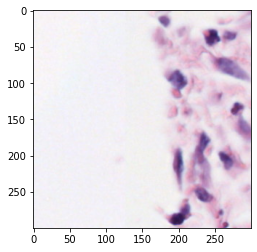

In [18]:
r =ds.iloc[10] 
#enlarged_tile = Spot.enlarge_tile(*r.tile, n_degrees = 45)

# read image
r = ds.iloc[2]
img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
result = Spot.mask_outside_of_enclosed_cyrcle(img)
Spot.check_scarce_tissue(result)

plt.imshow(img)
plt.show()

In [19]:
Spot.check_scarce_tissue(img)

False

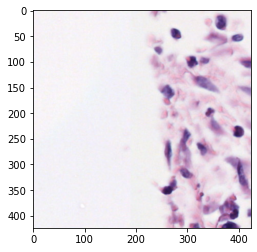

In [20]:
ti = r.tile
x,y,size,level = eval(r.tile_rot_augmentation)
enlarged_tile = Spot.get_tile(Spot, x,y,size,level, path= r.path, tif_name = r.tif_fn)

plt.imshow(enlarged_tile)
plt.show()

In [21]:
IntToFloatTensor()

IntToFloatTensor: (TensorMask,object) -> encodes
(TensorImage,object) -> encodes (TensorImage,object) -> decodes

In [22]:
timg =Tensor(array(enlarged_tile)).permute(2,0,1)/255.
timg.shape,type(timg)

(torch.Size([3, 424, 424]), torch.Tensor)

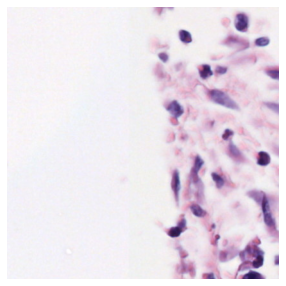

In [23]:
show_image(enlarged_tile)

In [24]:
Rotate(max_deg=45, p=1.)

AffineCoordTfm: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes 

torch.Size([1, 3, 424, 424])


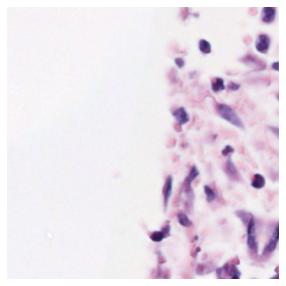

In [25]:
rot = Rotate(max_deg=45, p=1.)
img_rot = rot(TensorImage(timg).unsqueeze(0)) #add 1 dimension for batch as rotation in fastai is a batch augmentation
print(img_rot.shape)
show_image(img_rot.squeeze(0))

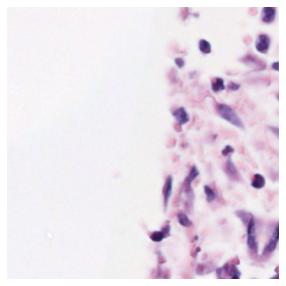

In [26]:
rsz = CropPad(300)
img_crop = rsz(img_rot)
show_image(img_crop.squeeze(0))

In [27]:

class Crop(Transform):
    def __init__(self, sz,**kwargs):
        super().__init__(**kwargs)
        self.sz = sz
        
        
    def encodes(self,i:TensorImage) -> TensorImage:
        y,x = i.shape[-2:] 
        return i[...,y//2-self.sz[0]//2:y//2-self.sz[0]//2+self.sz[0], x//2-self.sz[1]//2:x//2-self.sz[1]//2+self.sz[1] ]
        

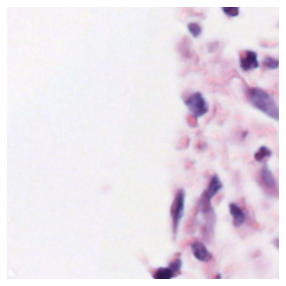

In [28]:
rsz = Crop((300,300))

img_crop = rsz(img_rot)

show_image(img_crop.squeeze(0))

In [29]:
ds.patient_ID = ds.patient_ID.astype(str) #Patient ID should be converted to str as both ints and str are mixed

In [30]:
ds.patient_ID.nunique()

922

In [31]:
ds.patient_ID = ds.patient_ID.astype('object')
print(ds.patient_ID.dtype)

object


In [32]:
ds.iloc[0]

tile                     [13400, 6238, (300, 300), 0]
path                     DTS2019                     
tif_fn                   TMA06-03                    
patient_ID               1173                        
label                    62.72                       
tile_rot_augmentation    [13337, 6175, (424, 424), 0]
Name: 0, dtype: object

In [33]:
ds.tif_fn.unique()

array(['TMA06-03', 'TMA06-04', 'TMA06-05', 'TMA06-06', 'TMA06-07',
       'TMA06-08', 'TMA06-09', 'TMA06-10', 'TMA06-12', 'TMA06-15',
       'TMA08-15', 'TMA08-16', 'TMA08-17', 'TMA08-18', 'TMA08-33',
       'TMA08-34', 'TMA08-36', 'TMA08-37', 'TMA08-38', 'TMA08-46',
       'TMA08-68', 'TMA08-70', 'TMA08-72', 'TMA09-22', 'TMA09-37',
       'TMA09-46', 'TMA14-04', 'TMA14-06', 'TMA06-11', 'TMA08-35 (2)',
       'TMA20-002', 'TMA20-003', 'TMA20-004', 'TMA20-005', 'TMA20-006'],
      dtype=object)

In [34]:
#change label by choosing other field from df_label
d = ds.merge(df_labels, how='left', left_on='patient_ID',right_on='COD_DTS', )
d = d.loc[d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'].isna() == False]
d.label = d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'].apply(lambda x: x)
d.label = True
d.loc[d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'] == "inestable",'label' ] = False

In [35]:
d.label.describe()

count     471923
unique    2     
top       True  
freq      452686
Name: label, dtype: object

In [36]:
d.label.unique()

array([ True, False])

In [37]:
# number of tiles in dataset 
d.shape[0]

471923

In [38]:
#generate training and validation partition avoiding patient overlap
# First: order dataset by patient ID
d.sort_values(['patient_ID'], inplace = True)
d.reset_index(drop=True, inplace=True)
# Second: assign 75% training and 30% validation from ordered dataset 
cut = int(0.75 * d.shape[0])
sep = d.iloc[cut]
cut = d.loc[d.patient_ID == sep.patient_ID].index[0]  #include all tiles of the the current patient in validation set


#idxs = np.random.permutation(range(d.shape[0]))
#train_files = d.iloc[idxs[:cut]]
#valid_files = d.iloc[idxs[cut:]]
train_files = d.iloc[:cut]
print(train_files.label.describe())
valid_files = d.iloc[cut:]
valid_files.label.describe()

count     353448
unique    2     
top       True  
freq      346252
Name: label, dtype: object


count     118475
unique    2     
top       True  
freq      106434
Name: label, dtype: object

In [39]:
train_files.iloc[13]

tile                                          [62900, 12021, (300, 300), 0]
path                                          DTS2019                      
tif_fn                                        TMA06-12                     
patient_ID                                    00-11988                     
label                                         True                         
tile_rot_augmentation                         [62837, 11958, (424, 424), 0]
COD_DTS                                       00-11988                     
Epicolon1+2IHQ-IMS-maria paper lynlike_IMS    estable                      
LynchIMS                                      esporadico                   
ihq_mlh1                                      positiu                      
dukes_r                                       II                           
TNMagrup                                      NaN                          
BaseEP1y2actualizada2016-OSCAR-def_n          NaN                          
grado_di    

In [40]:
def get_x(r):
    img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
    t = torch.Tensor(np.array(img))
    t = t.permute(2,0,1).float()/255.0
    return TensorImage(t)

def get_y(r): return  TensorCategory(r.label).long()

In [41]:
ds

,tile,path,tif_fn,patient_ID,label,tile_rot_augmentation
0,"[13400, 6238, (300, 300), 0]",DTS2019,TMA06-03,1173,62.72,"[13337, 6175, (424, 424), 0]"
1,"[13400, 6538, (300, 300), 0]",DTS2019,TMA06-03,1173,62.72,"[13337, 6475, (424, 424), 0]"
2,"[13400, 6838, (300, 300), 0]",DTS2019,TMA06-03,1173,62.72,"[13337, 6775, (424, 424), 0]"
3,"[13400, 7138, (300, 300), 0]",DTS2019,TMA06-03,1173,62.72,"[13337, 7075, (424, 424), 0]"
4,"[13700, 5512, (300, 300), 0]",DTS2019,TMA06-03,1173,62.72,"[13637, 5449, (424, 424), 0]"
...,...,...,...,...,...,...
1874,"[34200, 81200, (300, 300), 4]",DTS2019,TMA20-006,12056,50.06,"[33205, 80205, (424, 424), 4]"
1875,"[42700, 80700, (300, 300), 4]",DTS2019,TMA20-006,12031,74.21,"[41705, 79705, (424, 424), 4]"
1876,"[51100, 80300, (300, 300), 4]",DTS2019,TMA20-006,12017,60.28,"[50105, 79305, (424, 424), 4]"
1877,"[59400, 80200, (300, 300), 4]",DTS2019,TMA20-006,12008,74.42,"[58405, 79205, (424, 424), 4]"


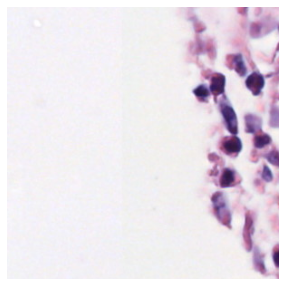

In [42]:
get_x(ds.iloc[3]).show()

In [43]:
train_ds = Datasets(train_files,[partial(get_x),get_y])
valid_ds = Datasets(valid_files,[get_x,get_y])

In [44]:
train_ds[0]

(TensorImage([[[0.9569, 0.9529, 0.9490,  ..., 0.4706, 0.5412, 0.6549],
          [0.9451, 0.9412, 0.9529,  ..., 0.4863, 0.5725, 0.6941],
          [0.9333, 0.9333, 0.9490,  ..., 0.4941, 0.5843, 0.7176],
          ...,
          [0.9686, 0.9765, 0.9765,  ..., 0.2392, 0.2235, 0.2314],
          [0.9412, 0.9451, 0.9373,  ..., 0.2902, 0.2824, 0.2863],
          [0.9608, 0.9608, 0.9608,  ..., 0.3804, 0.3686, 0.3529]],
 
         [[0.9373, 0.9333, 0.9294,  ..., 0.1922, 0.2471, 0.3529],
          [0.9373, 0.9294, 0.9333,  ..., 0.2078, 0.2784, 0.3922],
          [0.9255, 0.9216, 0.9294,  ..., 0.2196, 0.2941, 0.4157],
          ...,
          [0.9412, 0.9490, 0.9490,  ..., 0.1020, 0.0980, 0.0941],
          [0.9451, 0.9490, 0.9608,  ..., 0.1294, 0.1255, 0.1255],
          [0.9373, 0.9373, 0.9373,  ..., 0.1647, 0.1686, 0.1529]],
 
         [[0.9529, 0.9569, 0.9529,  ..., 0.4275, 0.4784, 0.5725],
          [0.9569, 0.9569, 0.9608,  ..., 0.4431, 0.5098, 0.6118],
          [0.9451, 0.9490, 0.9569, 

In [45]:
Datasets.__dict__

mappingproxy({'__module__': 'fastai2.data.core',
              '__doc__': 'A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`',
              '__init__': <function fastai2.data.core.Datasets.__init__(self, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs)>,
              '__getitem__': <function fastai2.data.core.Datasets.__getitem__(self, it)>,
              '__getattr__': <function fastai2.data.core.Datasets.__getattr__(self, k)>,
              '__dir__': <function fastai2.data.core.Datasets.__dir__(self)>,
              '__len__': <function fastai2.data.core.Datasets.__len__(self)>,
              '__iter__': <function fastai2.data.core.Datasets.__iter__(self)>,
              '__repr__': <function fastai2.data.core.Datasets.__repr__(self)>,
              'decode': <function fastai2.data.core.Datasets.decode(self, o, full=True)>,
              'subset': <function fastai2.data.core.Datasets.subset(self, i)>,
              '_new': <function fasta

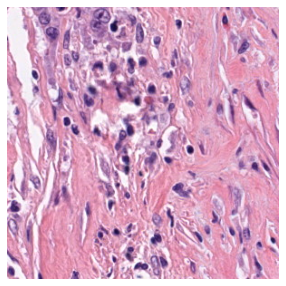

In [46]:
if hasattr(valid_ds, 'show'): valid_ds.show(valid_ds[0])

TensorCategory(1)


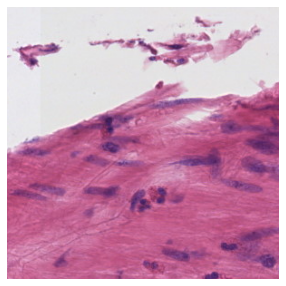

In [47]:
i = 40000
print(train_ds[i][1])
train_ds[i][0].show()

In [48]:
from fastai2.data.core import DataLoaders

In [49]:
ImageBlock

<function fastai2.vision.data.ImageBlock(cls=<class 'fastai2.vision.core.PILImage'>)>

In [236]:
from sklearn.utils.class_weight import compute_class_weight
labels = train_files.label.astype(int).values
w = compute_class_weight('balanced',np.unique(labels), labels)
wgts = w[labels]
print(wgts)
train_dl = WeightedDL(train_ds,wgts=wgts,shuffle=True,bs=128*2, 
                      after_batch=[Normalize.from_stats(*imagenet_stats), Rotate(max_deg=45, p=1.), Crop((300,300))],
                     device=default_device())
valid_dl = WeightedDL(valid_ds,wgts=None,bs=128,after_batch=[Normalize.from_stats(*imagenet_stats),])

[ 0.51039128  0.51039128  0.51039128 ... 24.55864369 24.55864369
 24.55864369]


In [237]:
train_dl.dataset.n_inp

1

In [244]:
train_dl.one_batch()

(TensorImage([[[[ 2.0680e+00,  2.0497e+00,  2.0394e+00,  ...,  2.0472e+00,
             2.0664e+00,  2.0594e+00],
           [ 2.0454e+00,  2.0263e+00,  2.0216e+00,  ...,  2.0345e+00,
             2.0426e+00,  2.0424e+00],
           [ 2.0463e+00,  2.0219e+00,  2.0129e+00,  ...,  2.0442e+00,
             2.0528e+00,  2.0593e+00],
           ...,
           [ 5.2146e-01,  6.3881e-01,  9.4217e-01,  ...,  2.0315e+00,
             2.0212e+00,  2.0071e+00],
           [ 3.0219e-01,  5.2962e-01,  9.4018e-01,  ...,  2.0128e+00,
             2.0128e+00,  2.0163e+00],
           [ 4.8109e-01,  8.0935e-01,  1.2507e+00,  ...,  2.0215e+00,
             2.0202e+00,  2.0310e+00]],
 
          [[ 2.1487e+00,  2.1390e+00,  2.1300e+00,  ...,  2.1212e+00,
             2.1414e+00,  2.1552e+00],
           [ 2.1660e+00,  2.1660e+00,  2.1612e+00,  ...,  2.1405e+00,
             2.1631e+00,  2.1747e+00],
           [ 2.1660e+00,  2.1615e+00,  2.1523e+00,  ...,  2.1614e+00,
             2.1930e+00,  2.1997e+

In [245]:
dls = DataLoaders(train_dl, valid_dl, device=default_device(), )

In [250]:

b = dls.one_batch()


In [251]:
explode_types(b)

{tuple: [fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory]}

In [254]:
@typedispatch
def show_batch(x:TensorImage, y:TensorCategory, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    plt.imshow(x[0].permute(2,1,0))
    
    for i in range_of(samples):
        show_image(x[i], title=y[i])
        

    return

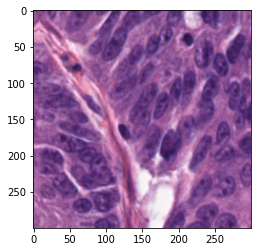

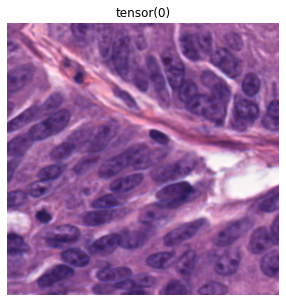

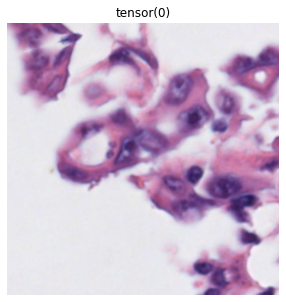

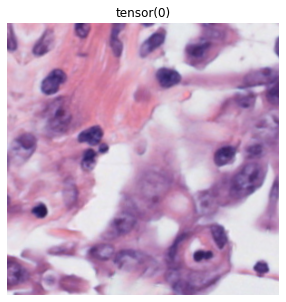

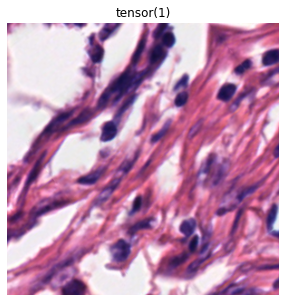

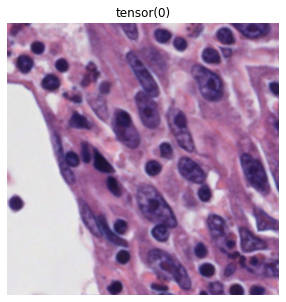

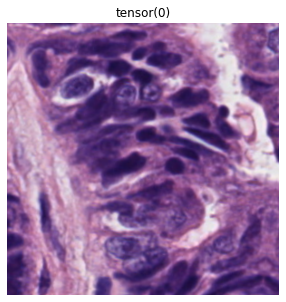

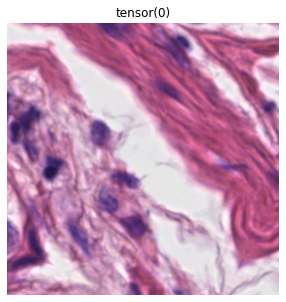

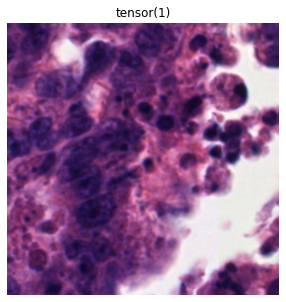

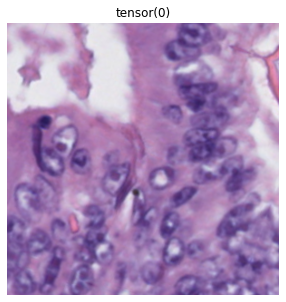

In [256]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34,
                    config={'ps':0, 'custom_head' : nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512 ,2))}, 
                    loss_func=CrossEntropyLossFlat(), normalize=False, metrics=accuracy ,n_out=2)
learn.to_parallel().to_fp16()
learn.unfreeze()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot_lr_find()

In [ ]:
learn.fit_one_cycle(2,1e-3)

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
preds = learn.get_preds()

In [ ]:
preds

In [ ]:
(preds[0] <= 0.5).sum()

In [ ]:
(preds[1] <= 0.5).sum()

In [ ]:
p = (preds[0] > 0.5).long();p

In [ ]:
accuracy(p,preds[1])

In [ ]:
((preds[0] > 0.5) == (preds[1] == 1)).sum().float()/preds[0].numel()

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.__dict__


In [ ]:
interp.losses.shape

In [ ]:
tma = tmas[1]

print(tma.meta_path)
print(tma.img_path_tif)

print(tma.spots[2].center)
spot = tma.spots[5]
jpg = spot.load_img_jpg()
tif = tma.load_img_tif()
tif

In [ ]:
tma.img_tif.properties
print(spot.TMA.name)
print(spot.name)
print(spot.ID)
print(spot.diameter)
spot.get_center_pixel()
print(spot.get_radious_pixel(0))
print(spot.get_circle_coordinates_pixel(0))
print(spot.check_tile_in_spot(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0]))
spot.get_tile(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0])

In [ ]:
img = spot.get_enclosing_box(4)
print(img.size)
img

In [ ]:
spot.tiles = []
print(len(spot.tiles))
for t in spot.sample_tiles(size = (300,300), level = 2, overlap = .3):
    print(t)
    

In [ ]:
print(len(spot.tiles))
print(spot.tiles[1])

In [ ]:
plt.imshow(spot.get_tile(*spot.tiles[0]))

In [ ]:
spot.get_tile(*spot.tiles[0])

In [ ]:
tma.img_tif.properties